In [1]:
import os
import time as timer
import numpy as np
import pickle

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.transforms as T

import visualization_utils as vu

# PCA on Fashion MNIST

## Define Constants

In [2]:
DATA_DIR = './data'
MODEL_DIR = './models'

## Load Fashion MNIST Dataset

In [4]:
training_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True, 
    download=True, 
    transform=T.ToTensor()
)

test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False, 
    download=True, 
    transform=T.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [5]:
X_train = training_data.data
X_test = test_data.data

[n, dx1, dx2] = X_train.shape
n, dx1, dx2

(60000, 28, 28)

### Reshape Train and Test Data

In [6]:
X_train_reshaped = torch.reshape(X_train, (-1, dx1*dx2)).float()
X_test_reshaped = torch.reshape(X_test, (-1, dx1*dx2)).float()

X_train_reshaped.shape, X_test_reshaped.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

### Visualize Some of the Data

img_np : 0.0 1.0


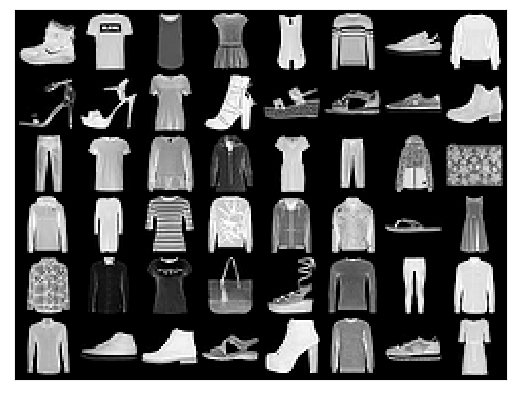

In [7]:
grid = vu.set_grid(X_train, num_cells=48)
vu.show(grid)

## Perform PCA - From Scratch

### 1. Covariance of X
Get the covariance of X_train_reshaped (transposed)

In [8]:
S = torch.cov(X_train_reshaped.T)
S, S.shape

(tensor([[8.5662e-03, 7.4621e-03, 7.4428e-03,  ..., 5.1517e-03, 5.5449e-03,
          6.2601e-03],
         [7.4621e-03, 6.2018e-02, 1.0761e-01,  ..., 1.5565e-01, 6.7165e-02,
          1.0657e-02],
         [7.4428e-03, 1.0761e-01, 5.8962e-01,  ..., 6.9410e-01, 1.9630e-01,
          3.8801e-02],
         ...,
         [5.1517e-03, 1.5565e-01, 6.9410e-01,  ..., 2.9786e+02, 1.0213e+02,
          8.6457e+00],
         [5.5449e-03, 6.7165e-02, 1.9630e-01,  ..., 1.0213e+02, 8.3416e+01,
          9.5062e+00],
         [6.2601e-03, 1.0657e-02, 3.8801e-02,  ..., 8.6457e+00, 9.5062e+00,
          4.3091e+00]]),
 torch.Size([784, 784]))

### 2. Compute Singular Value Decomposition (SVD) of S 

In [10]:
[U, D, V] = torch.linalg.svd(S)
U.shape, D.shape, V.shape

(torch.Size([784, 784]), torch.Size([784]), torch.Size([784, 784]))

In [11]:
"""
Define the value of k (num of principal components)
and
Define eigenvectors
"""
k = 100
W = U[:, :k]
W.shape

torch.Size([784, 100])

#### Show eigenvectors Representation

img_np : 0.0 1.0


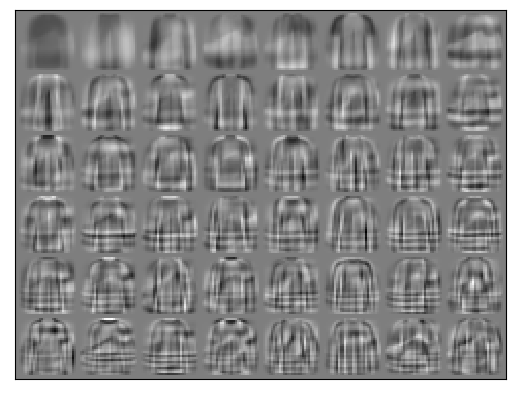

In [15]:
ev = torch.reshape(W.T, (-1, dx1, dx2))
grid = vu.set_grid(ev, num_cells=48)
vu.show(grid)

### 3. Reduce Dimension (Latent Representation)

In [13]:
Z_train = torch.matmul(X_train_reshaped, W)
Z_test = torch.matmul(X_test_reshaped, W)

Z_train.shape, Z_test.shape

(torch.Size([60000, 100]), torch.Size([10000, 100]))

### 4. Reconstruct the Data

In [14]:
X_train_recons = torch.matmul(Z_train, W.T)
X_test_recons = torch.matmul(Z_test, W.T)

X_train_recons.shape, X_test_recons.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

#### Show the Reconstructed Data

img_np : 0.0 1.0


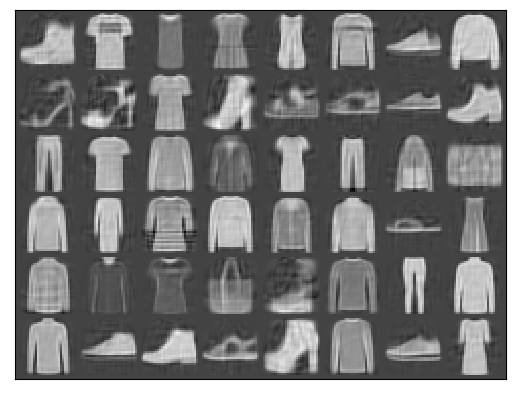

In [16]:
viz_recons = torch.reshape(X_train_recons, (-1, dx1, dx2))
grid = vu.set_grid(viz_recons, num_cells=48)
vu.show(grid)

img_np : 0.0 1.0


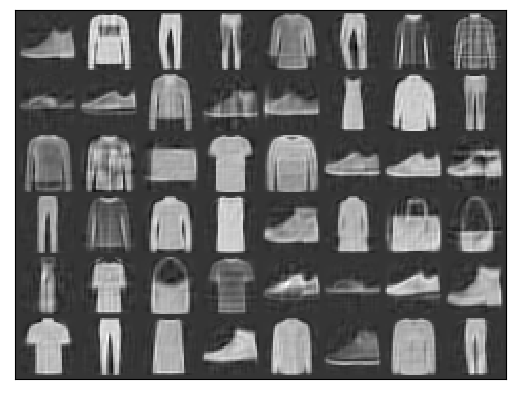

In [17]:
viz_recons = torch.reshape(X_test_recons, (-1, dx1, dx2))
grid = vu.set_grid(viz_recons, num_cells=48)
vu.show(grid)

### 5. Calculate the Proportion of Variance
Represents how much information of data will remain relatively to using all of them.

In [18]:
PoV = torch.sum(D[:k])/torch.sum(D)
PoV

tensor(0.9123)